In [1]:
%%capture
!pip install datasets==1.18.3
!git clone https://github.com/hammaad2002/PerturbationAnalysis.git
!pip install shap
!git clone https://github.com/hammaad2002/ASRAdversarialAttacks.git
%cd /kaggle/working/ASRAdversarialAttacks/
!pip install -r requirements.txt
%cd /kaggle/working/

In [2]:
from typing import Tuple, List
import torch
import torchaudio
import numpy as np
from tqdm.auto import tqdm
import librosa
import datasets
import shap
from datasets import load_dataset
import matplotlib.pyplot as plt
from ASRAdversarialAttacks.AdversarialAttacks import ASRAttacks
from PerturbationAnalysis.DataPipeline import DataTransform
from IPython.display import Audio
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

In [3]:
%%capture
# downloading TIMIT dataset from datasets library
timit = load_dataset("timit_asr")

In [4]:
# Loading the model from torchaudio model hub
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()

# Checking the device available during the current environment (CUDA is recommended!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initializing attack class
attack = ASRAttacks(model, device, bundle.get_labels())

# Initializing dataTransform class
dataTransformer = DataTransform(model, attack, device)

# Specifying the type of attack and the max number of audios on which to perform attack on
max_aud = 5  # number of example (audios) you want to work with
create_sentences = max_aud # number of audios should be equal to the number of random targeted sentences
sentences_for_random_transcription_vocab = 100 # number of sentences for creating dictionary for creating random transcriptions

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [5]:
#removing irrelevant columns from TIMIT dataset which we don't need
test_split = timit['test'].remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

**For generating random target whose number of words is equal to that of ground truth in batch**

In [6]:
# generating random target transcription
data = test_split['text']
orig, rand = dataTransformer.random_transcription_generator(data, sentences_for_dict = sentences_for_random_transcription_vocab, 
                                                            create_sentences = create_sentences)

# FGSM targeted:

adv_attack = "FGSM"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0065, targeted = True)

# FGSM untargeted:

adv_attack = "FGSM"

aud = test_split['audio'][:max_aud]

clean, pert = dataTransformer.apply_attack(adv_attack, aud, epsilon = 0.0065, targeted = False)

# BIM targeted:

adv_attack = "BIM"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0015, alpha = 0.00009,
                                           num_iter = 3000, targeted = True)
                   
# BIM untargeted:

adv_attack = "BIM"

aud = test_split['audio'][:max_aud]

clean, pert = dataTransformer.apply_attack(adv_attack, aud, epsilon = 0.0015, alpha = 0.00009,
                                           num_iter = 3000, targeted = False)
                   
# PGD targeted:

adv_attack = "PGD"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0015, alpha = 0.00009,
                                           num_iter = 10000, targeted = True)

                   
# PGD untargeted:

adv_attack = "PGD"

aud = test_split['audio'][:max_aud]

clean, pert = dataTransformer.apply_attack(adv_attack, aud, epsilon = 0.0015, alpha = 0.00009,
                                           num_iter = 10000, targeted = False)


# CW targeted:

adv_attack = "CW"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0015, c = 10,
                                          learning_rate = 0.00001, num_iter = 10000, decrease_factor_eps = 1,
                                          num_iter_decrease_eps = 10, optimizer = None, nested = True, 
                                          early_stop = True, search_eps = False, targeted = True)

                   
# CW untargeted:

adv_attack = "CW"

aud = test_split['audio'][:max_aud]

clean, pert = dataTransformer.apply_attack(adv_attack, aud, epsilon = 0.0015, c = 10,
                                          learning_rate = 0.00001, num_iter = 10000, decrease_factor_eps = 1,
                                          num_iter_decrease_eps = 10, optimizer = None, nested = True, 
                                          early_stop = True, search_eps = False, targeted = False)
         
# IMP_CW:

adv_attack = "IMP_CW"

aud = test_split['audio'][:max_aud]

target = rand

clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.015, c = 10, learning_rate1 = 0.001, 
                                    learning_rate2 = 0.0001, num_iter1 = 1000, num_iter2 = 15000, decrease_factor_eps = 1, 
                                    num_iter_decrease_eps = 10, optimizer1 = None, optimizer2 = "Adam",nested = True, 
                                    early_stop_cw = True, search_eps_cw = False, alpha = 0.05)

**Here we are performing targeted FGSM attack but for other attacks the codes are given above.**

**If you want to perform other attack just copy the code from above and paste it in the cell below.**

In [7]:
#performing attack on our audios in a single line
adv_attack = "FGSM"                  #specify the attack you want to perform
aud = test_split['audio'][:max_aud]  #no need to adjust this but the work of this is just to slice the dataset
target = rand                        #assigning random transcription to the variable target for improving readability of code
clean, pert = dataTransformer.apply_attack(adv_attack, aud, target = target, epsilon = 0.0065, targeted = True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
Audio(clean[0], rate = 16000)

In [9]:
Audio(pert[0], rate = 16000)

In [10]:
# Lets see the few perturbed transcriptions
number_of_example = 5
for i in range(number_of_example):
    temp = pert[i]
    print(attack.INFER(temp).replace("|"," "))

THE BOGELOW WIT PLUTPIT TI WAITED THROUGH THEVING 
DON'T AT EVERYN ER A RAG LIKE THAT 
ARE YOU THEIN FORINFOIMEN 
HE HAD YOUR DARK SU FREET BE WORT WATER ALL YEAR 
AT TWILIGHT OF TWELFTH DAY WILL TAK YO TI 


In [11]:
pad_clean = dataTransformer.pad_audios(clean)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
pad_pert = dataTransformer.pad_audios(pert)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
#Lets print their shapes before and after padding
print(f"Before padding the first clean audio had shape {clean[0].shape}")
print(f"After padding the first audio clean have shape {pad_clean[0].shape}")
print(f"Before padding the first perturbed audio had shape {pert[0].shape}")
print(f"After padding the first audio perturbed have shape {pad_pert[0].shape}")

Before padding the first clean audio had shape torch.Size([1, 44749])
After padding the first audio clean have shape torch.Size([1, 60416])
Before padding the first perturbed audio had shape torch.Size([1, 44749])
After padding the first audio perturbed have shape torch.Size([1, 60416])


In [14]:
#Compute stft on padded clean and perturbed audios
clean_stft = dataTransformer.stft_computer(pad_clean, return_db = True)
pert_stft = dataTransformer.stft_computer(pad_pert, return_db = True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

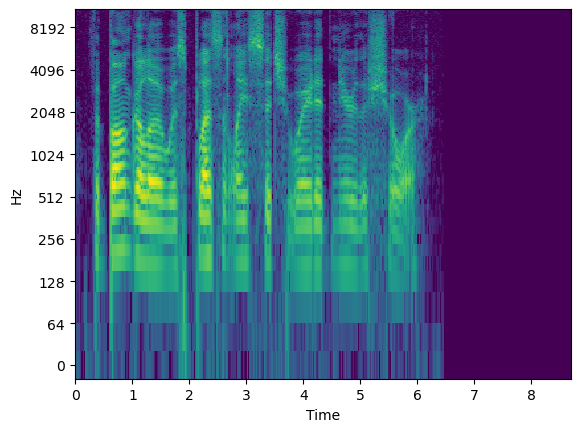

In [15]:
#Lets check the plot of these STFTs
librosa.display.specshow(clean_stft[0], x_axis = 'time', y_axis = 'log', cmap = 'viridis')

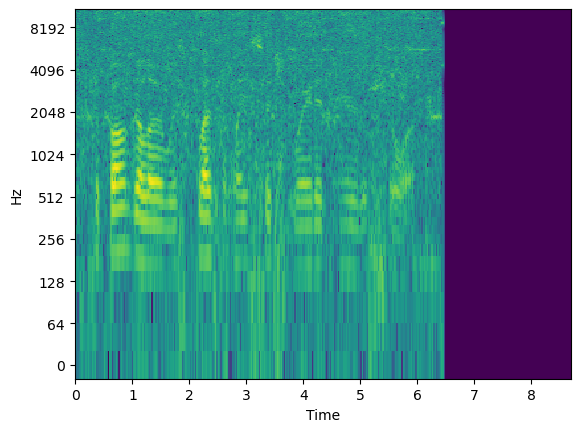

In [16]:
librosa.display.specshow(pert_stft[0], x_axis = 'time', y_axis = 'log', cmap = 'viridis')

In [17]:
#Compute zero crossing of clean and perturbed audios
clean_zc = dataTransformer.zero_crossing_computer(pad_clean)
pert_zc = dataTransformer.zero_crossing_computer(pad_pert)

In [18]:
# Lets check zero crossing of clean and perturbed audio
print(clean_zc[0])
print(pert_zc[0])

8143
18060


In [19]:
X, Y = dataTransformer.feature_combiner(clean_zc, clean_stft, pert_zc, pert_stft) #creating our features and target labels

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
tempDf = pd.DataFrame(X) #creating dataframe of features for displaying it over here
tempDf.head(5)

,0,1,2,3,4,5,6,7,8,9,...,96366,96367,96368,96369,96370,96371,96372,96373,96374,96375
0,-40.736542,-39.145817,-38.106350,-41.529964,-50.464066,-65.168121,-56.402771,-65.168121,-33.805965,-35.799404,...,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,8143.0
1,-48.547256,-41.843102,-37.399284,-36.610657,-37.656223,-38.913960,-41.237244,-52.245449,-72.855453,-72.398674,...,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,8246.0
2,-41.124695,-44.633148,-48.397766,-65.411110,-45.196266,-39.188198,-42.074791,-43.367577,-45.434151,-49.851608,...,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,4906.0
3,-45.282784,-42.420723,-40.500496,-40.137104,-39.760452,-40.262775,-42.611107,-41.780037,-43.275356,-52.538322,...,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,8610.0
4,-44.371407,-41.722012,-41.709679,-41.952572,-41.875263,-39.932964,-36.644974,-36.779213,-38.847729,-41.198086,...,-67.347900,-61.278728,-67.347900,-66.764481,-67.347900,-60.496159,-59.366127,-65.961441,-67.347900,11928.0


In [21]:
X = np.array(X)  #converting features to numpy array because of requirement of scikit-learn
Y = np.array(Y)  #converting target labels to numpy array because of requirement of scikit-learn

print(X.shape)   
print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(10, 96376)
(10,)
(8, 96376)
(2, 96376)
(8,)
(2,)


# <center> DECISION TREE

In [22]:
# Train the Decision Tree model
modelOne = DecisionTreeClassifier(random_state=42)
modelOne.fit(X_train, Y_train)

# Checking the accuracy using the Test set
modelOne.score(X_test, Y_test)

1.0

In [23]:
# Make predictions on the testing set
y_predOne = modelOne.predict(X_test)

# Evaluate the model performance
accuracyOne = (y_predOne == Y_test).mean()
print("Accuracy:", accuracyOne)

Accuracy: 1.0


In [24]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(max_aud*2)):
    example = X[i][np.newaxis, :]
    prediction = modelOne.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.


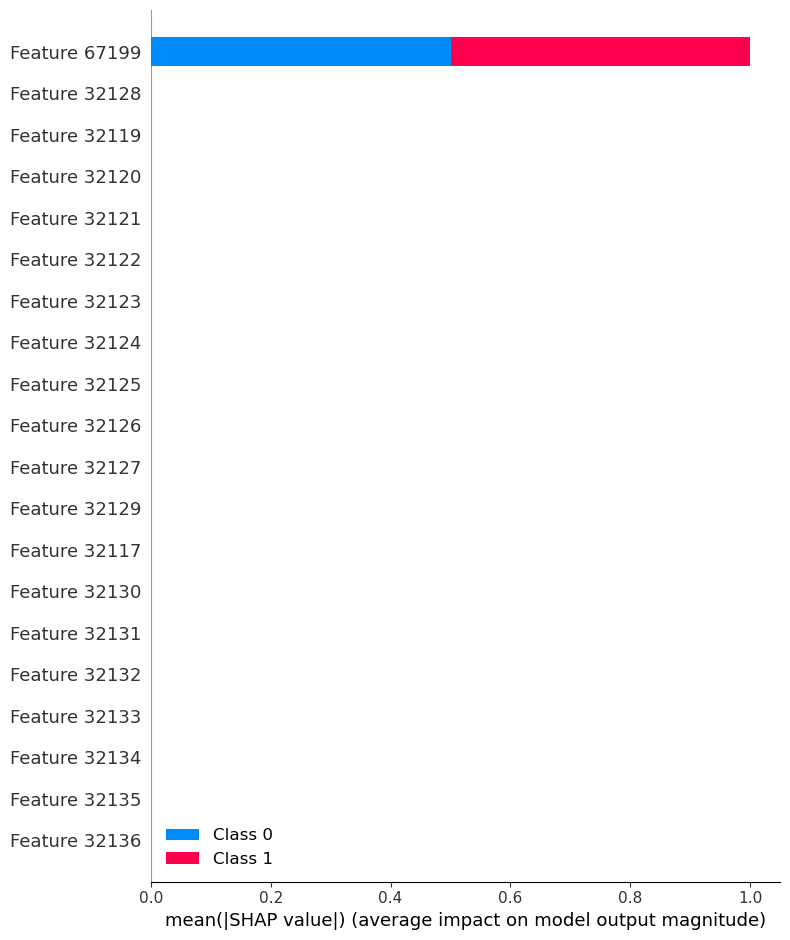

In [25]:
explainer = shap.TreeExplainer(modelOne)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

#<center> RANDOM FOREST

In [26]:
# Tran a Random Forest classifier
modelTwo = RandomForestClassifier(random_state=42)
modelTwo.fit(X_train, Y_train)

# Checking the accuracy using Test set
modelTwo.score(X_test, Y_test)

1.0

In [27]:
# Make predictions on the testing set
y_predTwo = modelTwo.predict(X_test)

# Evaluate the model performance
accuracyTwo = (y_predTwo == Y_test).mean()
print("Accuracy:", accuracyTwo)

Accuracy: 1.0


In [28]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(max_aud*2)):
    example = X[i][np.newaxis, :]
    prediction = modelTwo.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.


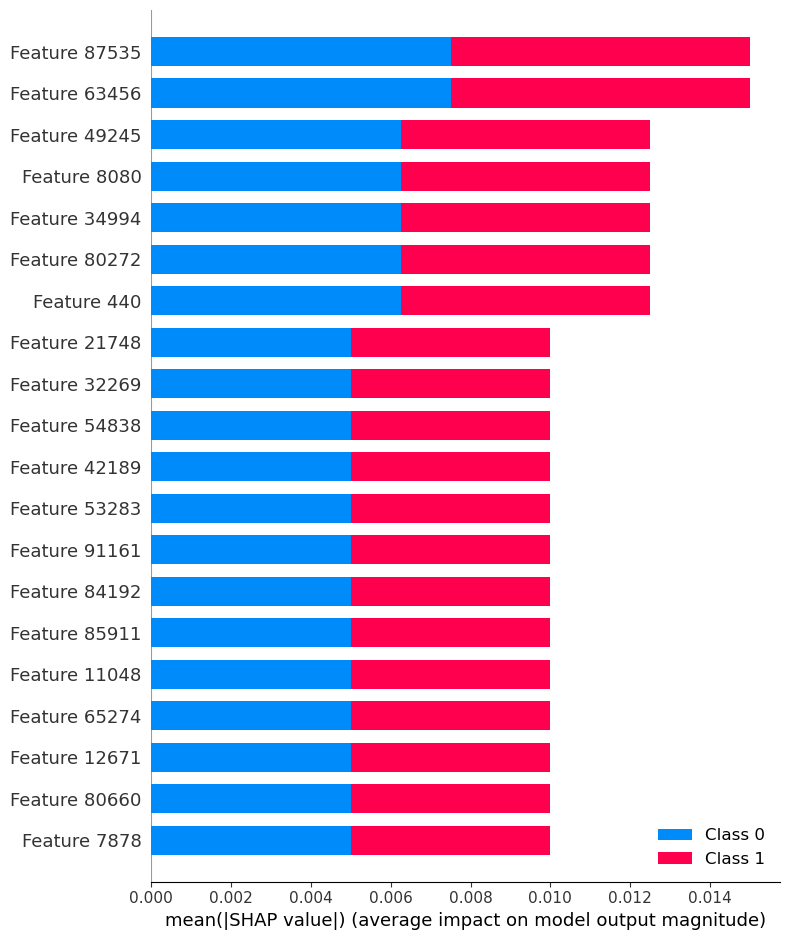

In [29]:
explainer = shap.TreeExplainer(modelTwo)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# <center> XGBOOST

In [30]:
# Train an XGBoost classifier
modelThree = XGBClassifier(random_state=42)
modelThree.fit(X_train, Y_train)

# Checking the accuracy using Test set
modelThree.score(X_test, Y_test)

1.0

In [31]:
# Make predictions on the testing set
y_predThree = modelThree.predict(X_test)

# Evaluate the model performance
accuracyThree = (y_predThree == Y_test).mean()
print("Accuracy:", accuracyThree)

Accuracy: 1.0


In [32]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(max_aud*2)):
    example = X[i][np.newaxis, :]
    prediction = modelThree.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.


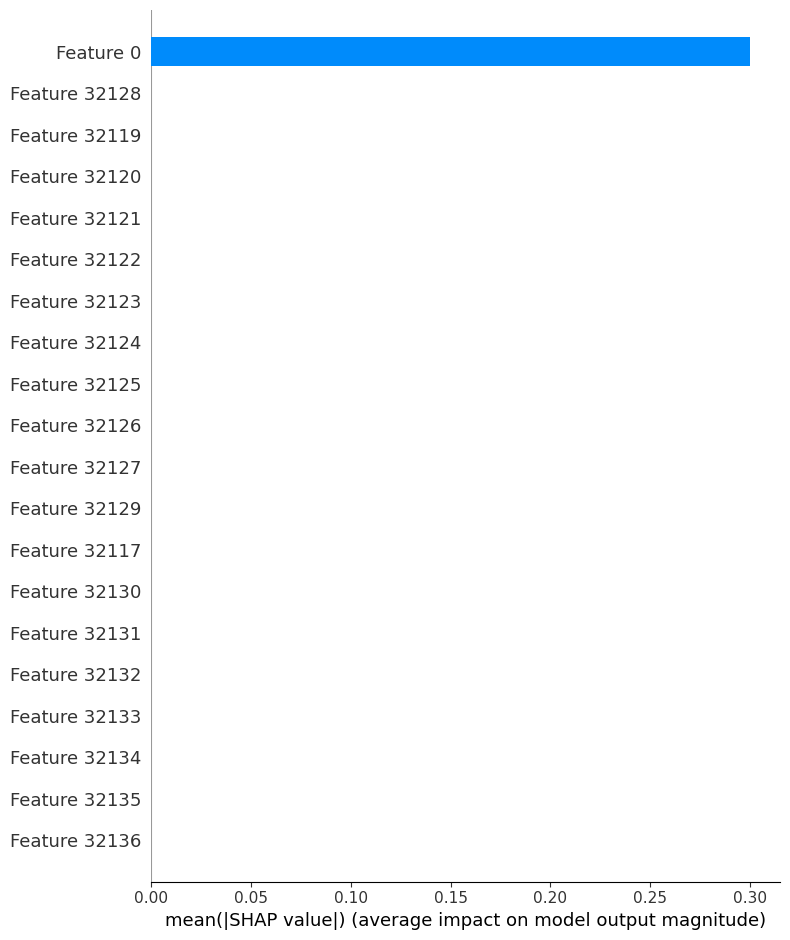

In [33]:
explainer = shap.TreeExplainer(modelThree)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# <center> LightGBM

In [34]:
# Train an XGBoost classifier
modelFour = LGBMClassifier(random_state=42)
modelFour.fit(X_train, Y_train)

# Checking the accuracy using Test set
modelFour.score(X_test, Y_test)

0.5

In [35]:
# Make predictions on the testing set
y_predFour = modelFour.predict(X_test)

# Evaluate the model performance
accuracyFour = (y_predFour == Y_test).mean()
print("Accuracy:", accuracyFour)

Accuracy: 0.5


In [36]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(max_aud*2)):
    example = X[i][np.newaxis, :]
    prediction = modelFour.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

Model's prediction is 0 and ground truth is 1.
Model's prediction is 0 and ground truth is 1.
Model's prediction is 0 and ground truth is 1.
Model's prediction is 0 and ground truth is 1.
Model's prediction is 0 and ground truth is 1.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.
Model's prediction is 0 and ground truth is 0.


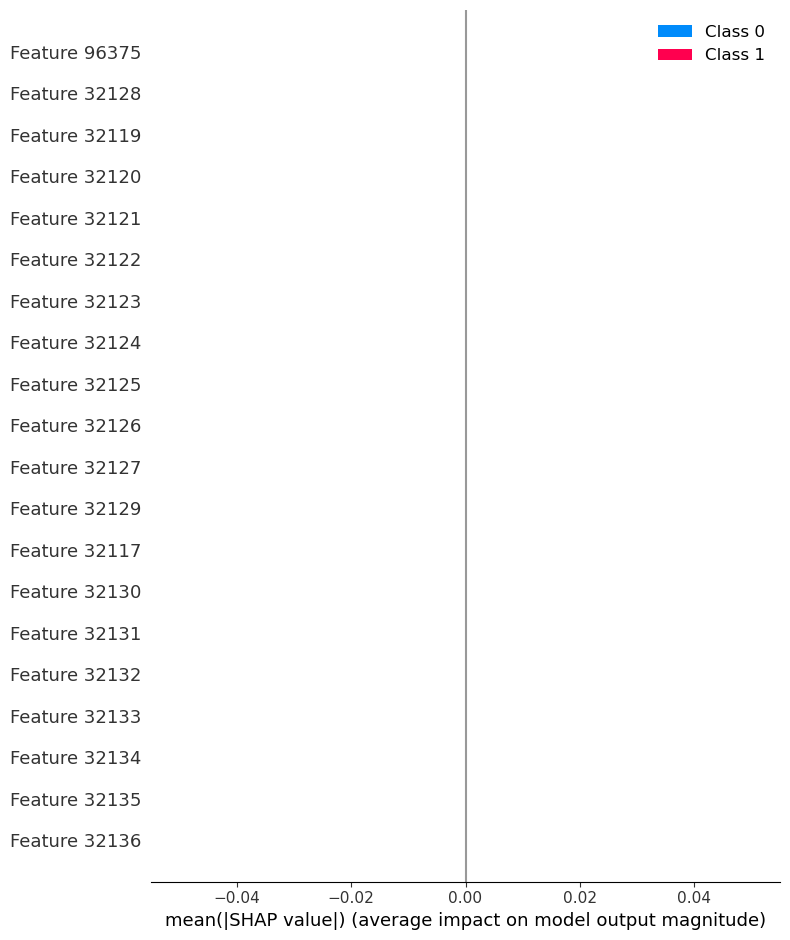

In [37]:
explainer = shap.TreeExplainer(modelFour)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# <center> Keras Neural Network (Simple DNN model)

In [38]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

modelFive = keras.Sequential([
    layers.Dense(512, activation="relu", input_shape=(X.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

modelFive.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy"])
modelFive.fit(X_train, Y_train, epochs=20, batch_size=2)

Epoch 1/20
4/4 [==============================] - 3s 10ms/step - loss: 928.5847 - accuracy: 0.6250
Epoch 2/20
4/4 [==============================] - 0s 9ms/step - loss: 771.2134 - accuracy: 0.7500
Epoch 3/20
4/4 [==============================] - 0s 9ms/step - loss: 611.0191 - accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 0s 8ms/step - loss: 311.4559 - accuracy: 0.5000
Epoch 5/20
4/4 [==============================] - 0s 9ms/step - loss: 335.1510 - accuracy: 0.2500
Epoch 6/20
4/4 [==============================] - 0s 8ms/step - loss: 127.9820 - accuracy: 0.8750
Epoch 7/20
4/4 [==============================] - 0s 8ms/step - loss: 678.7775 - accuracy: 0.2500
Epoch 8/20
4/4 [==============================] - 0s 8ms/step - loss: 147.0594 - accuracy: 0.6250
Epoch 9/20
4/4 [==============================] - 0s 8ms/step - loss: 127.7660 - accuracy: 0.8750
Epoch 10/20
4/4 [==============================] - 0s 8ms/step - loss: 314.6447 - accuracy: 0.3750
Epoch 11/20
4/4 [=

In [39]:
# Make predictions on the testing set
y_predFive = modelFive.predict(X_test)

# Evaluate the model performance
accuracyFive = (y_predFive == Y_test).mean()
print("Accuracy:", accuracyFive)

1/1 [==============================] - 0s 108ms/step
Accuracy: 0.5


In [40]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(max_aud*2)):
    example = X[i][np.newaxis, :]
    prediction = modelFive.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 24ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 24ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 21ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 22ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 24ms/step
Model's prediction is [0.] and ground truth is 0.
1/1 [==============================] - 0s 21ms/step
Model's prediction is [0.] and ground truth is 0.
1/1 [==============================] - 0s 25ms/step
Model's prediction is [0.] and ground truth is 0.
1/1 [==============================] - 0s 25ms/step
Model's prediction is [0.] and ground truth is 0.
1/1 [==============================] - 0s 26ms/step
Model's prediction is [1.] and

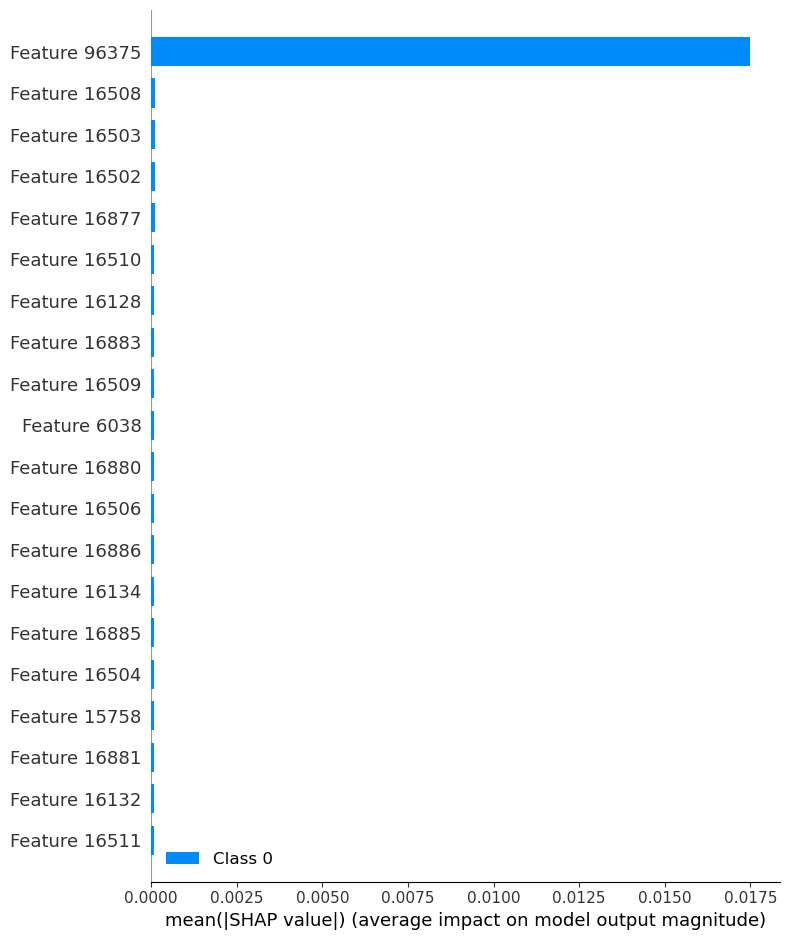

In [41]:
explainer = shap.DeepExplainer(modelFive, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")